## MTurk Dialect Analysis

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict

### Number of Rows

In [127]:
df = pd.read_csv(f'AAE.csv')
len(df)

68

#### Unique Workers

In [129]:
df["WorkerId"].value_counts()

WorkerId
A1Z7V1YPYOUWQW    19
A1014Q5VPQ3C6R    11
A1RW09KP0RNBKD    10
A123VRP2Z9FWFH     8
A3TBHH0AD6EJBU     3
A10NGUKUJXXUNV     2
A3QV8YWQFZICJK     2
A70E1IDLQXLCR      2
A1SARRYNMZDVXB     1
AI0E8NNAL3MRQ      1
A2I1C3OA51JP26     1
A58OLYOYP1Q66      1
A1HFOS3CF6E4PQ     1
A153M736KF00R7     1
A3R0XBLEYY99E4     1
A2DJQB4YZI1BBN     1
A2TZ84FWXKCHTF     1
APPR35OCKA8MC      1
A1JTAKTFE9RI70     1
Name: count, dtype: int64

#### Number of Unique Words

In [130]:
len(df["Input.Dialect_Word"].value_counts())

34

#### Average Time Spent on HIT (w/ Variance)

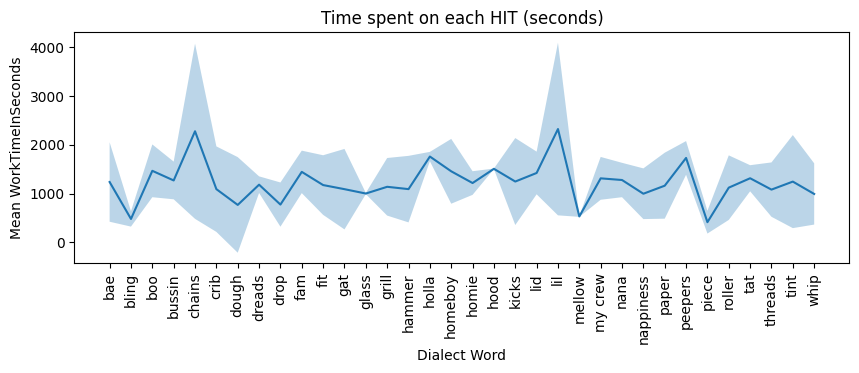

In [131]:
temp = df.groupby('Input.Dialect_Word')

M_new_vec = temp['WorkTimeInSeconds'].mean()
Sigma_new_vec = temp['WorkTimeInSeconds'].std()

lower_bound = M_new_vec - Sigma_new_vec
upper_bound = M_new_vec + Sigma_new_vec

plt.figure(figsize=(10, 3))
ax = plt.gca()

sns.lineplot(x=M_new_vec.index, y=M_new_vec.values, ax=ax)
ax.fill_between(M_new_vec.index, lower_bound, upper_bound, alpha=0.3)

ax.set_title('Time spent on each HIT (seconds)')
ax.set_xlabel('Dialect Word')
ax.set_ylabel('Mean WorkTimeInSeconds')

plt.xticks(rotation=90)
plt.show()

#### Consensus Plot

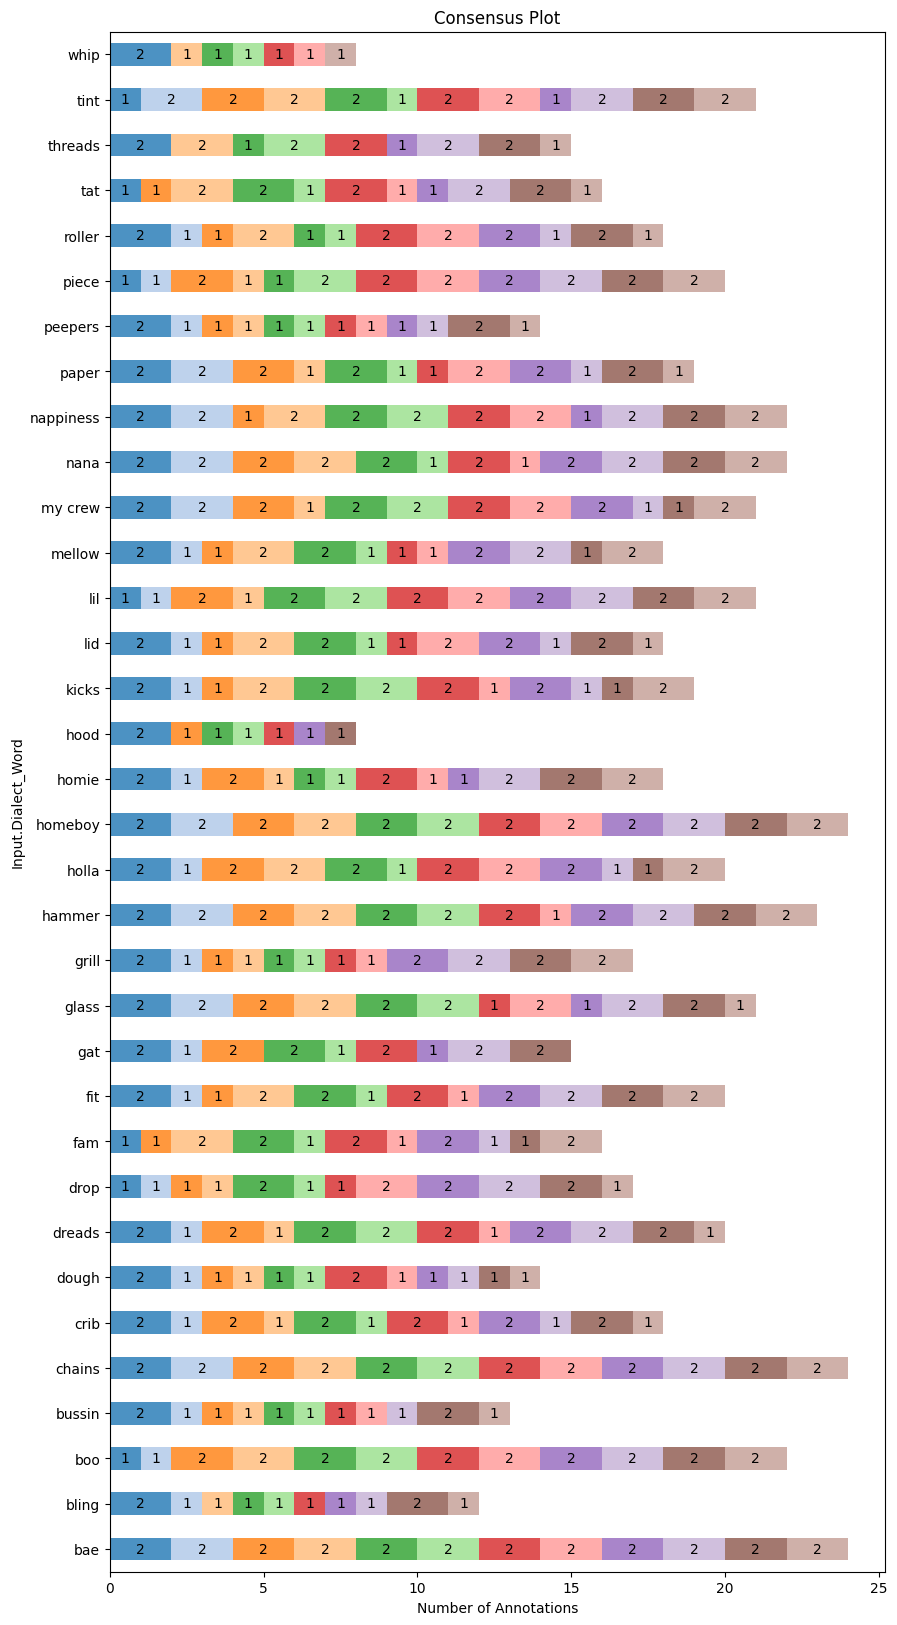

In [132]:
def get_consensus_df(df, label_prefixes):
    consensus = []
    for word in df['Input.Dialect_Word'].unique():
        sub_df = df[df['Input.Dialect_Word'] == word]
        d = defaultdict(int)
        for col in sub_df.columns:
            for label_prefix in label_prefixes:
                if label_prefix in col:
                    d[col] = sub_df[col].sum()
        consensus.append(d)
    return pd.DataFrame(consensus)

label_prefixes = ['Answer.prompt1-q1-yes.on', 
                  'Answer.prompt1-q2-yes.on', 
                  'Answer.prompt2-q1-yes.on', 
                  'Answer.prompt2-q2-yes.on',  
                  'Answer.prompt3-q1-yes.on', 
                  'Answer.prompt3-q2-yes.on',  
                  'Answer.prompt4-q1-yes.on', 
                  'Answer.prompt4-q2-yes.on',  
                  'Answer.prompt5-q1-yes.on', 
                  'Answer.prompt5-q2-yes.on',  
                  'Answer.prompt6-q1-yes.on', 
                  'Answer.prompt6-q2-yes.on',]

colors = [
    '#1f77b4', '#aec7e8',  # Blue shades
    '#ff7f0e', '#ffbb78',  # Orange shades
    '#2ca02c', '#98df8a',  # Green shades
    '#d62728', '#ff9896',  # Red shades
    '#9467bd', '#c5b0d5',  # Purple shades
    '#8c564b', '#c49c94'   # Brown shades
]

consensus_df = get_consensus_df(df, label_prefixes)

fig, ax = plt.subplots(figsize=(10, 20))
consensus_df.plot(kind='barh', stacked=True, alpha=0.8, ax=ax, color=colors)
for idx, row in consensus_df.iterrows():
    total = 0
    for col, val in row.items():
        if val > 0:
            ax.text(total + val / 2, idx, str(val), ha='center', va='center')
            total += val

ax.set_yticks(range(len(df['Input.Dialect_Word'].unique())))
ax.set_yticklabels(df['Input.Dialect_Word'].unique())
plt.title('Consensus Plot')
plt.xlabel('Number of Annotations')
plt.ylabel('Input.Dialect_Word')
ax.get_legend().remove()

plt.show()


#### Cohen's Kappa (per Word)

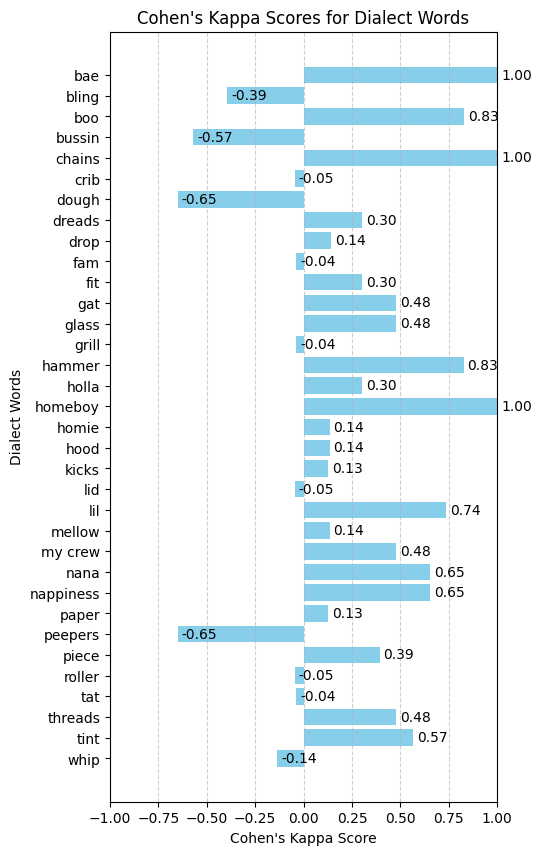

In [135]:
from sklearn.metrics import cohen_kappa_score

df = pd.read_csv('AAE.csv')
df_filtered = df.iloc[:, [27] + list(range(31, 67))]
columns_to_drop = [col for col in df_filtered.columns if 'idk.on' in col]
df_filtered = df_filtered.drop(columns=columns_to_drop, axis=1)

dialect_words = []
kappa_scores = []

for i in range(0, len(df_filtered), 2):
    annotator1 = df_filtered.iloc[i][2:].tolist()
    annotator2 = df_filtered.iloc[i + 1][2:].tolist()
    kappa = cohen_kappa_score(annotator1, annotator2)
    dialect_words.append(df_filtered.iloc[i]['Input.Dialect_Word'])
    kappa_scores.append(kappa)

plt.figure(figsize=(5, 10))
bars = plt.barh(dialect_words, kappa_scores, color='skyblue')
plt.xlabel("Cohen's Kappa Score")
plt.ylabel('Dialect Words')
plt.title("Cohen's Kappa Scores for Dialect Words")
plt.xlim(-1, 1)  
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar, kappa in zip(bars, kappa_scores):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, f'{kappa:.2f}', ha='left', va='center')

plt.show()

#### Annotator Agreeement (per Word)

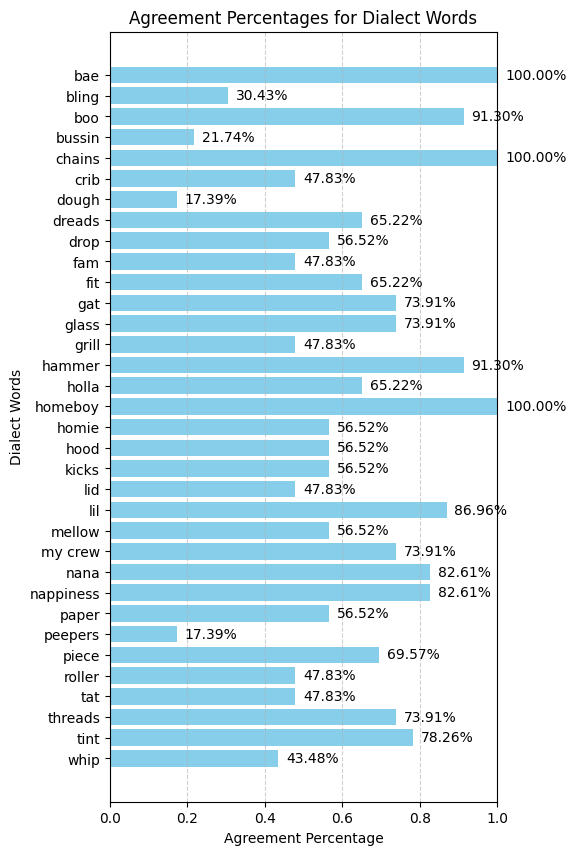

In [136]:
df = pd.read_csv('AAE.csv')
df_filtered = df.iloc[:, [27] + list(range(31, 67))]
columns_to_drop = [col for col in df_filtered.columns if 'idk.on' in col]
df_filtered = df_filtered.drop(columns=columns_to_drop, axis=1)

dialect_words = []
agreements = []

for i in range(0, len(df_filtered), 2):
    annotator1 = df_filtered.iloc[i][2:].tolist()
    annotator2 = df_filtered.iloc[i + 1][2:].tolist()
    
    numerator = sum(x == y for x, y in zip(annotator1, annotator2))
    agreement = numerator / len(annotator1)
    
    dialect_words.append(df_filtered.iloc[i]['Input.Dialect_Word'])
    agreements.append(agreement)

plt.figure(figsize=(5, 10))
bars = plt.barh(dialect_words, agreements, color='skyblue')
plt.xlabel("Agreement Percentage")
plt.ylabel('Dialect Words')
plt.title("Agreement Percentages for Dialect Words")
plt.xlim(0, 1)
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar, agreement in zip(bars, agreements):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, f'{agreement:.2%}', ha='left', va='center')

plt.show()

#### Cohen's Kappa (Overall)

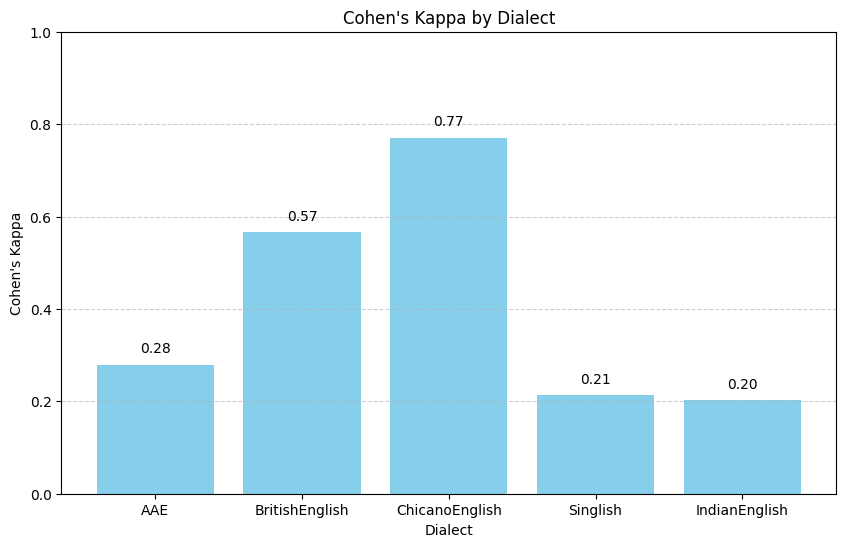

In [137]:
from sklearn.metrics import cohen_kappa_score

dialects = ['AAE', 'BritishEnglish', 'ChicanoEnglish', 'Singlish', 'IndianEnglish']

kappa_scores = []
for dialect in dialects:
    df = pd.read_csv(f"{dialect}.csv")
    annotator1_all, annotator2_all = [], []
    for i in range(0, len(df), 2):
        df_filtered_1 = df.iloc[i, [27] + list(range(31, 67))]
        df_filtered_1 = df_filtered_1[[label for label in df_filtered_1.index if 'idk.on' not in label]]
        df_filtered_1 = df_filtered_1.dropna()

        df_filtered_2 = df.iloc[i + 1, [27] + list(range(31, 67))]
        df_filtered_2 = df_filtered_2[[label for label in df_filtered_2.index if 'idk.on' not in label]]
        df_filtered_2 = df_filtered_2.dropna()

        annotator1 = df_filtered_1.to_list()
        annotator2 = df_filtered_2.to_list()

        annotator1_all.extend(annotator1[1:])
        annotator2_all.extend(annotator2[1:])

    kappa_scores.append(cohen_kappa_score(annotator1_all, annotator2_all))

plt.figure(figsize=(10, 6))
bar_plot = plt.bar(dialects, kappa_scores, color='skyblue')
plt.xlabel('Dialect')
plt.ylabel("Cohen's Kappa")
plt.title("Cohen's Kappa by Dialect")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar, score in zip(bar_plot, kappa_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{score:.2f}', ha='center', va='bottom')
    
plt.show()